# Digital Signal Processing - Riyal or Pake


## Preparation

In [16]:
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
FakePath = r"Audio\Training\fake"
RealPath = r"Audio\Training\real"

We then create a metadata to map the file path to the label

In [18]:
try:
    df = pd.read_csv("metadata.csv")
except:
    rows = []

    # for FAKE files
    for file in os.listdir(FakePath):
        if file.lower().endswith((".wav", ".mp3", ".flac")):
            rows.append([os.path.join(FakePath, file), "fake"])

    # for REAL files
    for file in os.listdir(RealPath):
        if file.lower().endswith((".wav", ".mp3", ".flac")):
            rows.append([os.path.join(RealPath, file), "real"])


    df = pd.DataFrame(rows, columns=["filepath", "label"])
    df.to_csv("metadata.csv", index=False)

df

,filepath,label
0,Audio\Training\fake\file1.mp3.wav_16k.wav_norm...,fake
1,Audio\Training\fake\file100.mp3.wav_16k.wav_no...,fake
2,Audio\Training\fake\file10003.mp3.wav_16k.wav_...,fake
3,Audio\Training\fake\file10012.wav_16k.wav_norm...,fake
4,Audio\Training\fake\file10017.wav_16k.wav_norm...,fake
...,...,...
10793,Audio\Training\real\file9974.wav_16k.wav_norm....,real
10794,Audio\Training\real\file9976.wav_16k.wav_norm....,real
10795,Audio\Training\real\file998.wav_16k.wav_norm.w...,real
10796,Audio\Training\real\file9983.wav_16k.wav_norm....,real


We then check the balance of the label to ensure our model didnt get bias

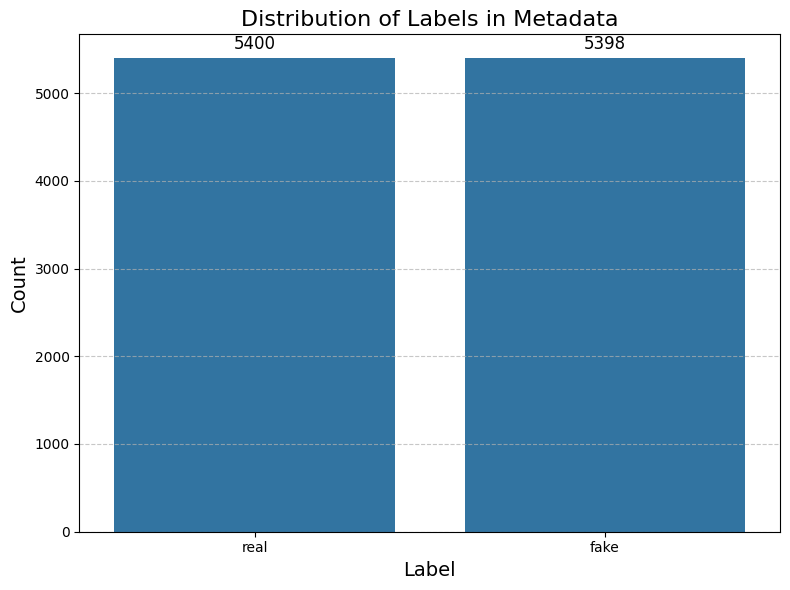

In [19]:
label_counts = df['label'].value_counts()

plt.figure(figsize=(8, 6))

sns.barplot(x=label_counts.index, y=label_counts.values)

plt.title('Distribution of Labels in Metadata', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

for i, count in enumerate(label_counts.values):
    plt.text(i, count + max(label_counts.values)*0.01, str(count),
             ha='center', va='bottom', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Feature Extraction

We use mfcc-20 to do feature extraction. We use sample rate of 16000 which are the standard and also extract features such as:
* Centroid & Bandwidth: To measure how bright and rich the voices is.
* ZCR & Roll-Off: To measure static noises and high-frequency cut-offs
* Variance: To measure the change in values for the voices

In [20]:
def extract_features(path):
    """
    function to extract features from audio file
    """
    y, sr = librosa.load(path, sr=16000)

    mfcc_feat = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20), axis=1)
    centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr), axis=1)
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr), axis=1)
    flatness = np.mean(librosa.feature.spectral_flatness(y=y), axis=1)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y), axis=1)

    return np.hstack([mfcc_feat, centroid, bandwidth, flatness, zcr])



In [21]:
try:
    X = np.load("X.npy")
    y = np.load("y.npy")
except:
    X = []
    y = []

    meta = df
    total = len(meta)
    for fp, label in zip(meta.filepath, meta.label):

        print(f"{meta.label}")
        X.append(extract_features(fp))
        y.append(0 if label == "fake" else 1)

    X = np.array(X)
    y = np.array(y)

In [22]:
df['filesize'] = df['filepath'].apply(lambda x: os.path.getsize(x))
duplicates_mask = df.duplicated(subset=['filesize', 'label'], keep='first')

X_clean = X[~duplicates_mask]
y_clean = y[~duplicates_mask]
df_clean = df[~duplicates_mask].reset_index(drop=True)

print(f"Clean Shape:  {X_clean.shape}")
print(f"Removed {X.shape[0] - X_clean.shape[0]} duplicates.")

X = X_clean
y = y_clean
df = df_clean

Clean Shape:  (10253, 24)
Removed 545 duplicates.


In [23]:
mfcc_cols = [f"mfcc_{i+1}" for i in range(20)]
other_cols = ["centroid", "bandwidth", "flatness", "zcr"]

columns = mfcc_cols + other_cols
columns.append("label")

df_features = pd.DataFrame(np.hstack([X, y.reshape(-1,1)]), columns=columns)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_features)

           mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0     -178.743073  126.461525  14.188124  34.700752   1.974662  -1.778040   
1     -172.757462  111.088242  -1.509959  47.279091 -17.711466   0.412784   
2     -119.931618   60.789570 -28.315762  -1.473958 -26.789444 -10.983577   
3     -205.076981   83.372200   1.067383  45.490017 -11.854851  -5.159760   
4     -257.010010  107.586235   3.686545  23.650019 -21.114876  12.464292   
...           ...         ...        ...        ...        ...        ...   
10248 -254.803680   88.288834  -9.297806  -2.221986 -30.051497 -16.789282   
10249 -241.842209   64.115997   6.878798  18.746532 -27.746037 -20.786375   
10250 -152.968781   74.326363  -9.814979  43.357830 -15.322787  33.380253   
10251 -186.030609   92.343658  -0.227718  12.126911 -40.669472 -30.967260   
10252 -215.273224   89.468414 -17.153082   6.340302 -22.352608 -16.775812   

          mfcc_7     mfcc_8     mfcc_9    mfcc_10    mfcc_11    mfcc_12  \


In [24]:
mfcc_cols = [f'mfcc_{i+1}' for i in range(20)]

desc = df_features[mfcc_cols].describe()

variance = df_features[mfcc_cols].var()
desc.loc['var'] = variance

print(desc)

             mfcc_1        mfcc_2        mfcc_3        mfcc_4        mfcc_5  \
count  10253.000000  10253.000000  10253.000000  10253.000000  10253.000000   
mean    -185.506815     94.340417     -5.173639     27.566550    -14.916396   
std       46.795558     30.930342     20.125859     18.503514     16.557439   
min     -472.698090    -12.579007   -112.644203    -44.587002    -77.603050   
25%     -216.694077     72.090744    -18.166737     13.576057    -27.404707   
50%     -185.317032     90.509605     -2.603275     27.935974    -17.046825   
75%     -151.291611    113.399895      8.420585     40.401875     -2.211803   
max       51.870354    214.706024     58.265293    119.102455     40.411480   
var     2189.824226    956.686079    405.050194    342.380044    274.148797   

             mfcc_6        mfcc_7        mfcc_8        mfcc_9       mfcc_10  \
count  10253.000000  10253.000000  10253.000000  10253.000000  10253.000000   
mean      -4.930741    -14.960602    -11.081812    

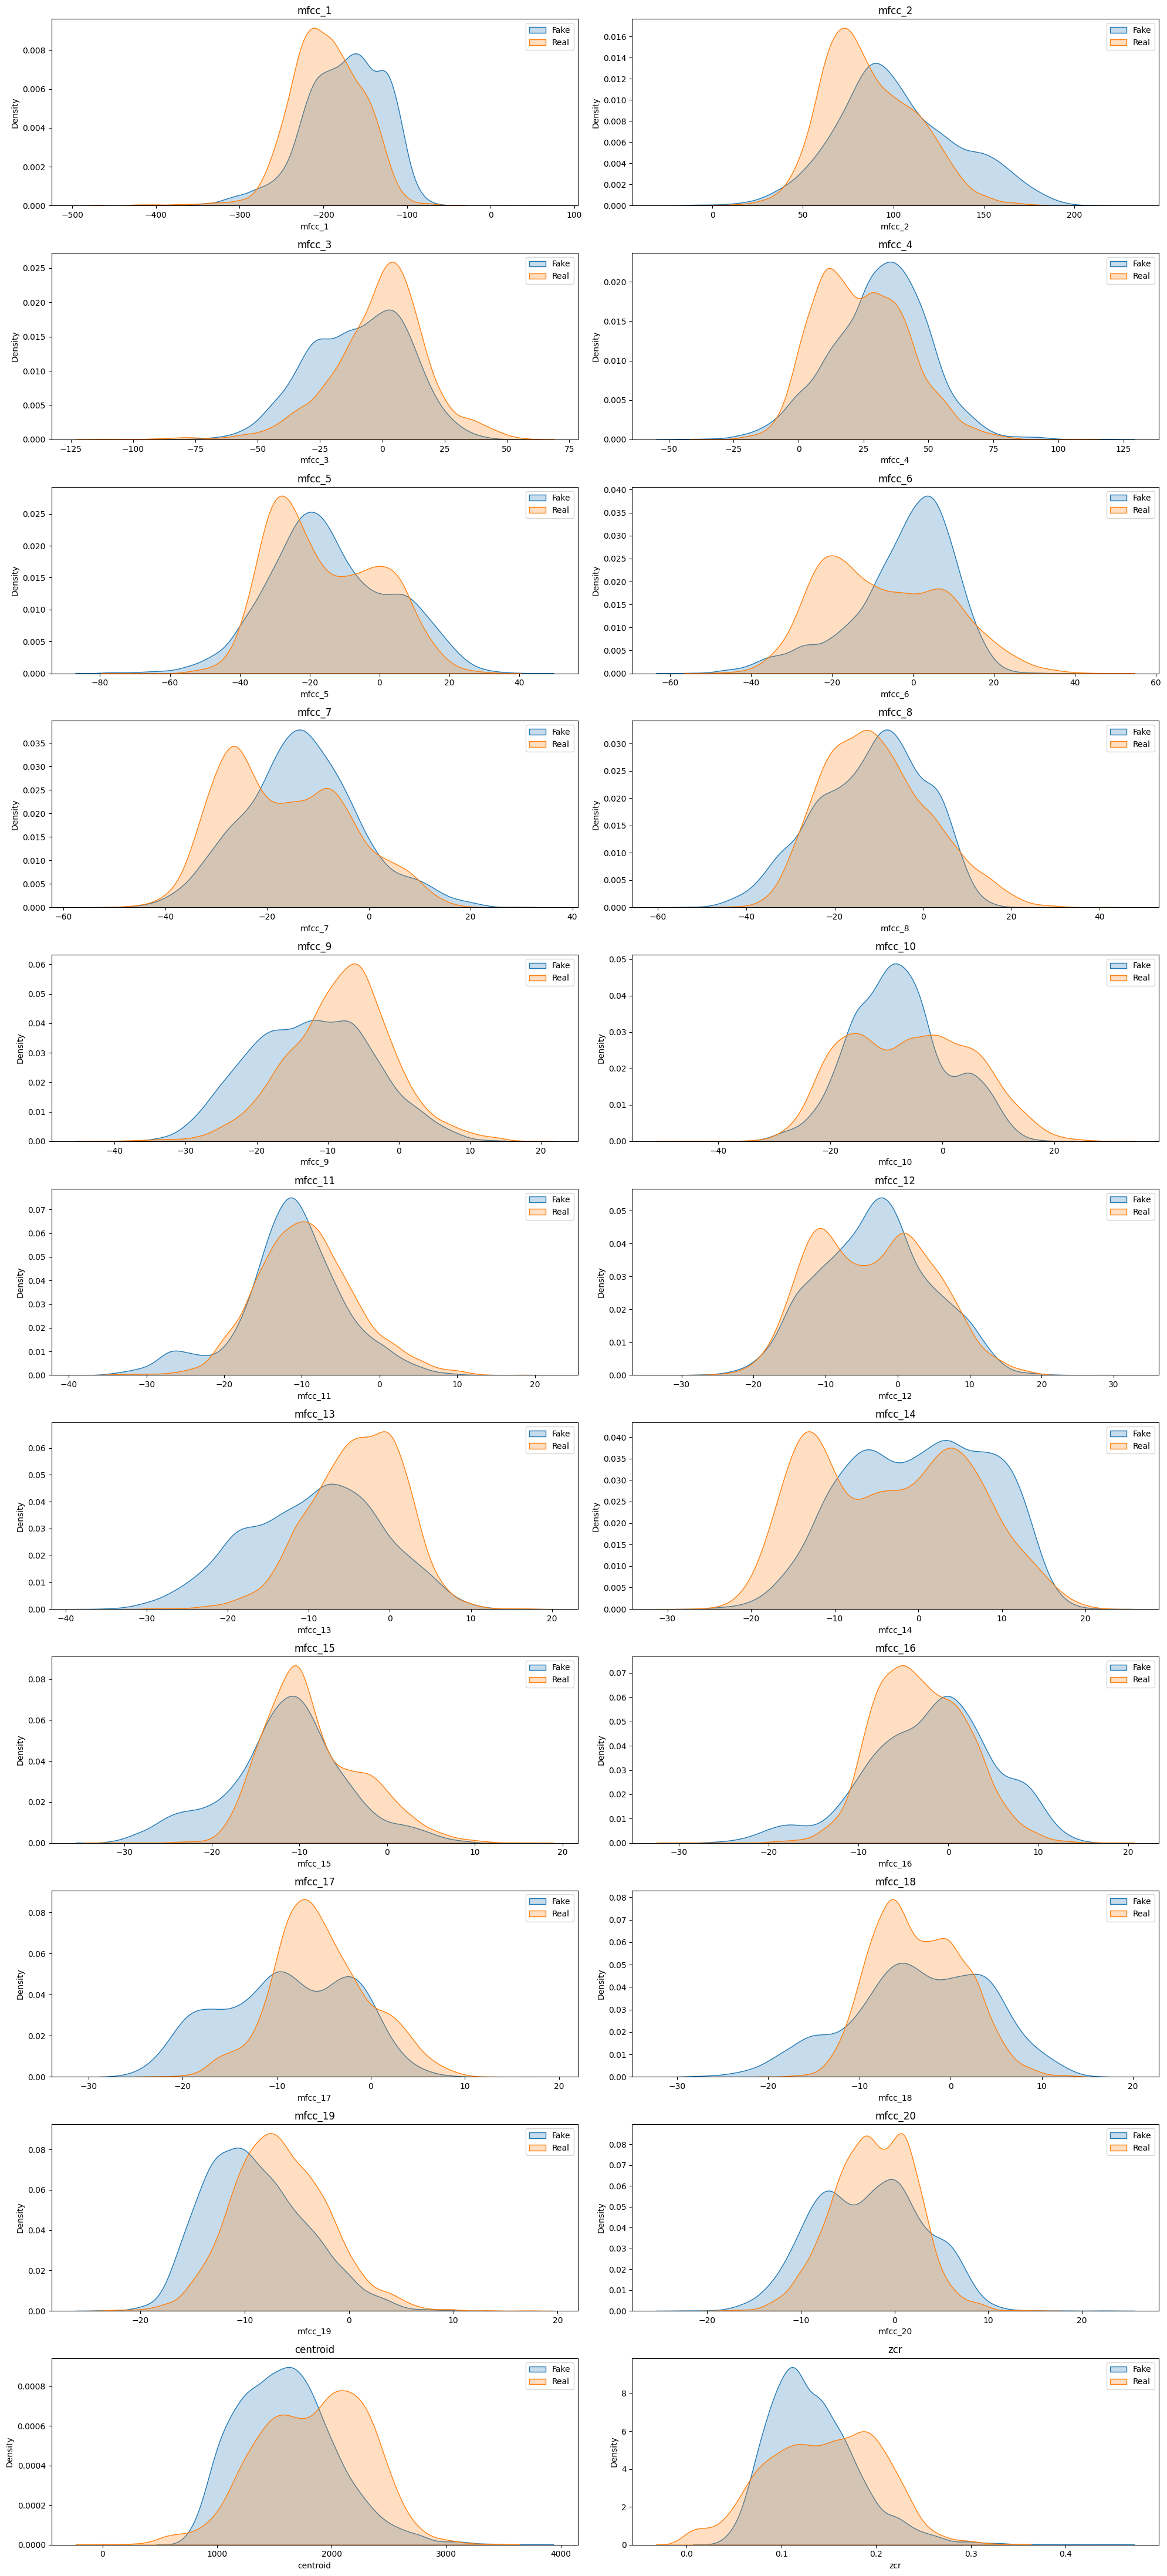

In [25]:
df_fake = df_features[df_features['label'] == 0]
df_real = df_features[df_features['label'] == 1]

mfcc_cols = [f'mfcc_{i+1}' for i in range(20)]
key_features = mfcc_cols + ['centroid', 'zcr']

fig, axes = plt.subplots(11, 2, figsize=(20, 44))
axes = axes.flatten()

for ax, feature in zip(axes, key_features):
    sns.kdeplot(df_fake[feature], label='Fake', fill=True, ax=ax)
    sns.kdeplot(df_real[feature], label='Real', fill=True, ax=ax)
    ax.set_title(f'{feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()


## Dimension Reduction

If we look at the correlation heatmap below, we will see that some features are having too much correlation. Meaning that we need to do reduction dimension

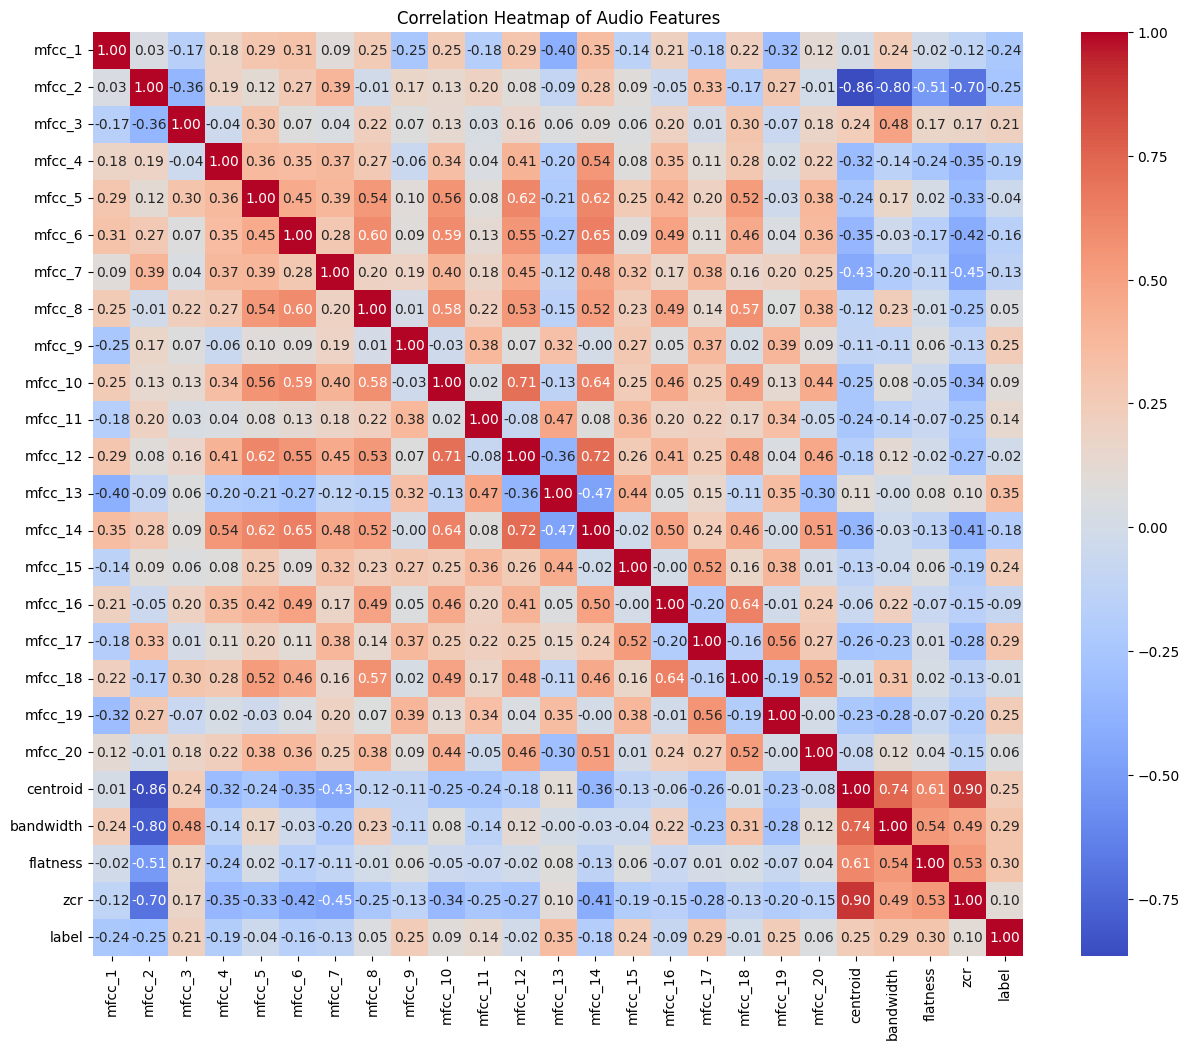

In [26]:
plt.figure(figsize=(15, 12))
sns.heatmap(df_features.corr(numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap of Audio Features')
plt.show()

Firstly before do dimension reduction, we need to check the skewness

In [27]:
print(df_features.skew().sort_values())

bandwidth   -0.665256
mfcc_13     -0.499399
mfcc_3      -0.409154
mfcc_1      -0.408845
mfcc_17     -0.260730
mfcc_6      -0.208998
mfcc_18     -0.184727
mfcc_16     -0.169585
mfcc_9      -0.133857
mfcc_11     -0.091522
mfcc_14     -0.058388
mfcc_20     -0.053497
label       -0.052889
mfcc_15      0.046007
mfcc_8       0.060380
mfcc_12      0.094736
mfcc_4       0.128897
centroid     0.168328
mfcc_10      0.196045
mfcc_5       0.201802
mfcc_7       0.242731
mfcc_19      0.303078
zcr          0.313941
mfcc_2       0.470618
flatness     2.658779
dtype: float64


Usually a skewness in range of -0.5 to +0.5 is ok, but as we can see that both bandwith and flatness is out of those ranges. Bandwith is fine but flatness is obviusly need a handling

In [28]:
df_features['flatness'] = np.sqrt(df_features['flatness']) # Use squared transform
print(df_features[['flatness']].skew().sort_values())

flatness    0.099605
dtype: float64


We will also check the outliers

In [29]:
Q1 = df_features[['centroid', 'zcr']].quantile(0.25)
Q3 = df_features[['centroid', 'zcr']].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask = (df_features[['centroid', 'zcr']] < (lower_bound)) | (df_features[['centroid', 'zcr']] > (upper_bound))
outliers = mask.sum()

outlier_rows = df_features[mask.any(axis=1)]
print(outliers)
print('\n')
print("Outlier if:")
print(f"centroid < {lower_bound['centroid']} or > {upper_bound['centroid']}")
print("OR")
print(f"zcr < {lower_bound['zcr']} or > {upper_bound['zcr']}")
print('\n')
print(f"Found {len(outlier_rows)} outlier")

centroid    37
zcr         65
dtype: int64


Outlier if:
centroid < 339.00130145571325 or > 3098.0084320185742
OR
zcr < -0.01580531556986771 or > 0.2934039742256416


Found 76 outlier


However not all outlier is bad, the paper actually keeps most outlier and only delete the silence

In [30]:
silencer_mask = (df_features['zcr'] < 0.0001) | (df_features['centroid'] < 100)
silencer_rows = df_features[silencer_mask]
print(f"Found {len(silencer_rows)} silence")

Found 10 silence


In [31]:
keep = ~silencer_mask
df_features = df_features[keep]
X_ = X[keep]
y_ = y[keep]

X = X_
y = y_

But, before we do PCA, we need to split and scale the data first

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now we can do the PCA

In [33]:
n_features = X_train_scaled.shape[1]

if n_features > 65:
    pca = PCA(n_components=65)
else:
    pca = PCA(n_components=0.95)

X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

# Modelling (Gradient Boost Classifier)

We decided to use GBClassifier because based on the paper we read that the method are the best for this spesific dataset.
Though there is method such as XGBoost which is the direct upgrade of the models, the vanilla GBClassfier still got the upperhand.

In [34]:
gb_model = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,1000
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None



FINAL ACCURACY: 97.80%
              precision    recall  f1-score   support

        Fake       0.98      0.98      0.98      1028
        Real       0.98      0.98      0.98      1021

    accuracy                           0.98      2049
   macro avg       0.98      0.98      0.98      2049
weighted avg       0.98      0.98      0.98      2049



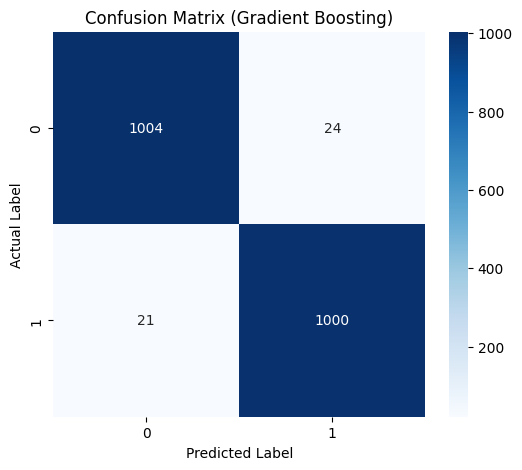

In [35]:
y_pred = gb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nFINAL ACCURACY: {acc*100:.2f}%")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Gradient Boosting)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [36]:
def predict_audio(audio_path, model, scaler, pca):
    """
    funct to predict an unlabeled audio
    """
    f = extract_features(audio_path)
    f = f.reshape(1, -1)
    f = scaler.transform(f)
    f = pca.transform(f)
    prediction = model.predict(f)
    label = "FAKE" if prediction[0] == 0 else "REAL"
    return label

In [37]:
import os
from IPython.display import Audio

audio_files = [
    r"Audio\Testing\Fake bgt.wav",
    r"Audio\Testing\Real bgt.wav"
]

for filename in audio_files:
    if os.path.exists(filename):
        try:
            display(Audio(filename))
            prediction = predict_audio(filename, gb_model, scaler, pca)

            color = "\033[92m" if prediction == "REAL" else "\033[91m"
            reset = "\033[0m"
            print(f"{filename} → {color}{prediction}{reset}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")
    else:
        print(f"File not found: {filename}")


Audio\Testing\Fake bgt.wav → FAKE


Audio\Testing\Real bgt.wav → REAL


## Spectogram

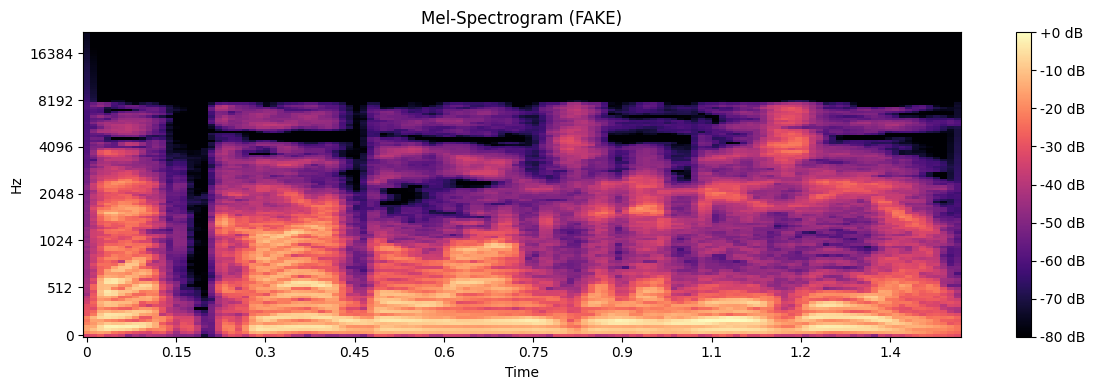

In [38]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

df_f = df[df['label'] == 'fake'].reset_index(drop=True)
label = df_f['label'].iloc[0]
path = df_f['filepath'].iloc[0]


y, sr = librosa.load(path, sr=44100)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=22050)

S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, sr=sr,
                         x_axis='time',
                         y_axis='mel',
                         fmax=22050,
                         cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram ({label.upper()})')
plt.tight_layout()
plt.show()

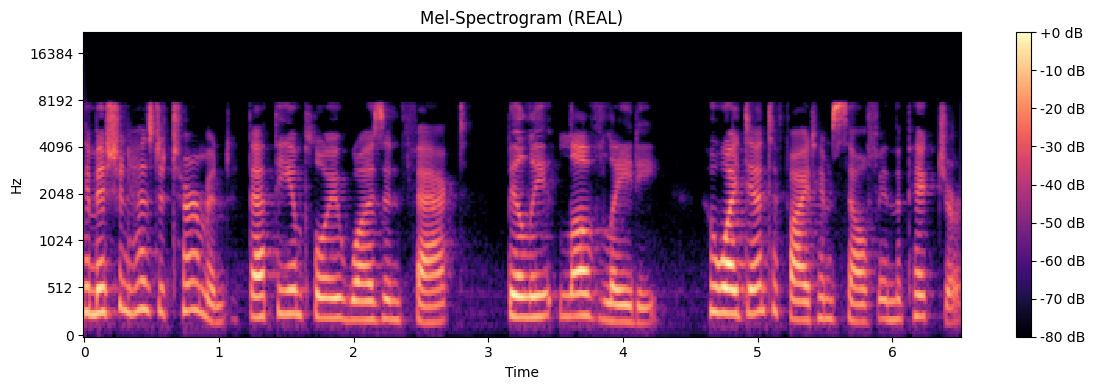

In [39]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

df_r = df[df['label'] == 'real']
label = df_r['label'].iloc[0]
path = df_r['filepath'].iloc[0]

y, sr = librosa.load(path, sr=44100)

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=22050)

S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_dB, sr=sr,
                         x_axis='time',
                         y_axis='mel',
                         fmax=22050,
                         cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-Spectrogram ({label.upper()})')
plt.tight_layout()
plt.show()

In [ ]:
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(gb_model, "models/gb_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(pca, "models/pca.pkl")


['models/pca.pkl']